In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import os,gc
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
torch.cuda.set_device(2)
print (torch.cuda.current_device())
#os.environ['CUDA_VISIBLE_DEVICES'] = "2,3,4,5,6,7"

2


In [ ]:
def Image_Processing(img_path, crop_size=224):
    img = Image.open(img_path).convert('RGB').resize((256, 256),Image.ANTIALIAS) #open and resize
    #crop and normalize
    transform_sequence = transforms.Compose([
                                             #transforms.ToPILImage(), #if not PILImage
                                             transforms.CenterCrop(crop_size),
                                             transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
                                             #transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
                                            ])
    img = transform_sequence(img)#.numpy() #tensor to numpy
    return img
    
#preparing the trainset and  testset
img_path = '/data/fjsdata/NIH-CXR/images/images/' 
trI = torch.FloatTensor()
trY = torch.FloatTensor()
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/train.txt', "r") as file_descriptor: #tarinset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]
            image = Image_Processing(os.path.join(img_path, image_name))
            image = torch.unsqueeze(image,0)# extend the dimension
            trI = torch.cat((trI, image), 0) 
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = np.array([int(i) for i in image_label]) #list ->numpy
            image_label = torch.from_numpy(image_label).type(torch.FloatTensor)#numpy->tensor
            image_label = torch.unsqueeze(image_label,0)
            trY = torch.cat((trY, image_label), 0) #concatenate   
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(trI.size()[0],78468))
        sys.stdout.flush()  

valI = torch.FloatTensor()
valY = torch.FloatTensor()
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/val.txt', "r") as file_descriptor: #valset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]
            image = Image_Processing(os.path.join(img_path, image_name))
            image = torch.unsqueeze(image,0)# extend the dimension
            valI = torch.cat((valI, image), 0) 
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = np.array([int(i) for i in image_label]) #list ->numpy
            image_label = torch.from_numpy(image_label).type(torch.FloatTensor)#numpy->tensor
            image_label = torch.unsqueeze(image_label,0)
            valY = torch.cat((valY, image_label), 0) #concatenate        
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(valI.size()[0],11219))
        sys.stdout.flush()  

teI = torch.FloatTensor()
teY = torch.FloatTensor()
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/test.txt', "r") as file_descriptor: #testset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]
            image = Image_Processing(os.path.join(img_path, image_name))
            image = torch.unsqueeze(image,0)# extend the dimension
            teI = torch.cat((teI, image), 0) 
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = np.array([int(i) for i in image_label]) #list ->numpy
            image_label = torch.from_numpy(image_label).type(torch.FloatTensor)#numpy->tensor
            image_label = torch.unsqueeze(image_label,0)
            teY = torch.cat((teY, image_label), 0) #concatenate 
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(teI.size()[0],22433))
        sys.stdout.flush()  

3813 / 78468 

In [ ]:
# construct model
class DenseNet121(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet121, self).__init__()
        self.dense_net_121 = torchvision.models.densenet121(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_121.classifier.in_features
        self.dense_net_121.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_121(x)
        return x


class DenseNet169(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet169, self).__init__()
        self.dense_net_169 = torchvision.models.densenet169(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_169.classifier.in_features
        self.dense_net_169.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_169(x)
        return x


class DenseNet201(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet201, self).__init__()
        self.dense_net_201 = torchvision.models.densenet201(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_201.classifier.in_features
        self.dense_net_201.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_201(x)
        return x

In [4]:
#model training
N_CLASSES = 14 #class numbers
model = DenseNet121(num_classes=N_CLASSES, is_pre_trained=True).cuda()#initialize model
#model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5, 6, 7]).cuda()# make model available multi GPU cores training
torch.backends.cudnn.benchmark = True  # improve train speed slightly
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min')
criterion = torch.nn.BCELoss()
#train model
best_net, best_loss = None, float('inf')
batchSize = 30 #'Batch Size': 32
for epoch in range(10):#'Max Epoch': 1000
    lens = trI.size()[0]
    num_batches = lens // batchSize + 1
    model.train()  # set network as train mode
    with torch.autograd.enable_grad():
        for i in range(num_batches):
            optimizer.zero_grad()#grad vanish
            min_idx = i * batchSize
            max_idx = np.min([lens, (i+1)*batchSize])
            I_batch = trI[min_idx:max_idx].cuda()
            y_batch = trY[min_idx:max_idx].cuda()
            #forword
            y_outputs = model(I_batch.permute(0, 3, 1, 2))#permute the dims of matrix
            #loss
            loss = criterion(y_outputs, y_batch)
            loss.backward()
            #update parameters
            optimizer.step()
            sys.stdout.write('\r {} / {} : train loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
            sys.stdout.flush()     
    #validation process
    loss_val = []
    mean_loss_tensor = 0.
    lens = valI.size()[0]
    num_batches = lens // batchSize  +1
    model.eval()  # set network as eval mode without BN & Dropout
    with torch.autograd.no_grad():
        for j in range(num_batches):
            min_idx = j * batchSize
            max_idx = np.min([lens, (j+1)*batchSize])
            I_batch = valI[min_idx:max_idx].cuda()
            y_batch = valY[min_idx:max_idx].cuda()
            y_outputs = model(I_batch.permute(0, 3, 1, 2))#forword
            curr_loss = criterion(y_outputs, y_batch)
            sys.stdout.write('\r {} / {} : validation loss = {}'.format(j + 1, num_batches, float('%0.6f'%curr_loss.item()) ) )
            sys.stdout.flush()  
            mean_loss_tensor += curr_loss  # tensor op.
            loss_val.append(curr_loss.item())
    mean_loss_tensor = mean_loss_tensor / len(valY)  # tensor
    scheduler.step(mean_loss_tensor.item())
    print("Eopch: %5d val_loss = %.6f" % (epoch + 1, np.mean(loss_val)))
    if np.mean(loss_val) < best_loss:
        best_loss = np.mean(loss_val)
        best_net = copy.deepcopy(model)        
print("best_loss = %.6f" % (best_loss))
model = model.cpu()#release gpu memory
torch.cuda.empty_cache()

RuntimeError: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]

In [ ]:
#performance of testset
# initialize the ground truth and output tensor
gt = torch.FloatTensor().cuda()
pred = torch.FloatTensor().cuda()
lens = teI.size()[0]
num_batches = lens // batchSize  +1
best_net.eval()  # set network as eval mode without BN & Dropout
with torch.autograd.no_grad():
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([lens, (i+1)*batchSize])
        I_batch = teI[min_idx:max_idx].cuda()
        y_batch = teY[min_idx:max_idx].cuda()
        gt = torch.cat((gt, y_batch), 0)
        y_outputs = best_net(I_batch.permute(0, 3, 1, 2))#forword
        pred = torch.cat((pred, y_outputs.data), 0)
        sys.stdout.write('\r {} / {} '.format(i, num_batches))
        sys.stdout.flush()
    
CLASS_NAMES = ['Atelectasis', 'Cardiomegaly', 'Effusion','Infiltration', 'Mass', 'Nodule', 'Pneumonia', \
               'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'] 
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

AUROCs = compute_AUCs(gt, pred)
AUROC_avg = np.array(AUROCs).mean()
print('The average AUROC is {AUROC_avg:.4f}'.format(AUROC_avg=AUROC_avg))
for i in range(N_CLASSES):
    print('The AUROC of {} is {:.4f}'.format(CLASS_NAMES[i], AUROCs[i]))

In [ ]:
img_paths = []
img_labels = []
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/test.txt', "r") as file_descriptor: #testset
    lines = file_descriptor.readlines()
    for line in lines:
        line_items = line.split()
        image_name = line_items[0].split('/')[1]
        img_path = os.path.join(img_path, image_name)
        img_paths.append(img_path)
        img_label = line_items[1:]  # 14 labels from index 2
        img_labels.append(img_label)    

In [ ]:
#show raw image after resizing and cropping      
raw_img = Image.open(img_paths[0]).convert('RGB').resize((256, 256),Image.ANTIALIAS)
width, height = raw_img.size   # Get dimensions
left = (width - 224)/2
top = (height - 224)/2
right = (width + 224)/2
bottom = (height + 224)/2
raw_img = raw_img.crop((left, top, right, bottom)) 
plt.imshow(raw_img)
plt.axis('off') 
plt.show()  

In [ ]:
#class activation maps
best_net_feat = best_net.module.dense_net_121.features
weights = list(best_net_feat.parameters())[-2]# select the last convolution layers' weights as weights of CAM
best_net_feat.eval()  # set network as evaluation model
best_net_feat.cuda()
with torch.autograd.no_grad():
    input_img = Image_Processing(img_paths[0]).unsqueeze_(0).cuda() 
    output_img = best_net_feat(input_img.permute(0, 3, 1, 2))#forword

# start generating heat map
heat_map = None
for i in range(0, len(weights)):
    tmp_map = var_output[0, i, :, :]
    if i == 0:
        heat_map = self.weights[i] * tmp_map
    else:
        heat_map += self.weights[i] * tmp_map

# convert cuda tensor to cpu numpy nd-array
heat_map = heat_map.cpu().data.numpy()

# blend raw image and heat map
raw_img = cv2.imread(path_to_raw_image, 1)
raw_img = cv2.resize(raw_img, (224, 224))

cam = heat_map / np.max(heat_map)
cam = cv2.resize(cam, (trans_crop, trans_crop))
heat_map = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)

output_img = heat_map * 0.5 + raw_img   

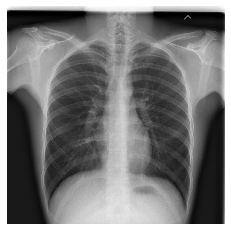

In [6]:
img = Image.open('/data/fjsdata/NIH-CXR/images/images/00028178_000.png')
plt.imshow(img, cmap='gray')
plt.axis('off') 
plt.show()

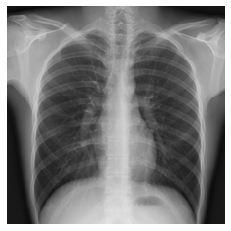

In [5]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transform_list = list()
transform_list.append(transforms.Resize(256))
#transform_list.append(transforms.ToTensor())
transform_list.append(normalize)
transform_sequence = transforms.Compose(transform_list)
img = Image.open('/data/fjsdata/NIH-CXR/images/images/00028178_000.png').convert('RGB').resize((256, 256),Image.ANTIALIAS)
#print(np.asarray(img).shape)
#print(np.asarray(img).min())
#print(np.asarray(img).max())
width, height = img.size   # Get dimensions
left = (width - 224)/2
top = (height - 224)/2
right = (width + 224)/2
bottom = (height + 224)/2
img = img.crop((left, top, right, bottom)) 
plt.imshow(img)
plt.axis('off') 
plt.show()
#img = transform_sequence(img)
#print(img.size())
#print(img.min())
#print(img.max())

torch.Size([3, 224, 224])
tensor(-0.9294)
tensor(0.7961)
(224, 224, 3)
0
254


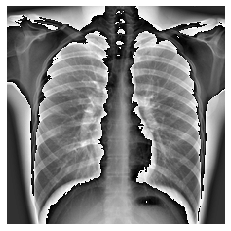

In [27]:
def Image_Processing(img_path, crop_size=224):
    img = Image.open(img_path).convert('RGB').resize((256, 256),Image.ANTIALIAS) #open and resize
    #crop and normalize
    transform_sequence = transforms.Compose([
                                             #transforms.ToPILImage(), #if not PILImage
                                             transforms.CenterCrop(crop_size),
                                             transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
                                             transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
                                            ])
    img = transform_sequence(img)
    return img #tensor

img = Image_Processing('/data/fjsdata/NIH-CXR/images/images/00028178_000.png')
print(img.size())
print(img.min())
print(img.max())
img = transforms.ToPILImage()(img).convert('RGB')
print(np.asarray(img).shape)
print(np.asarray(img).min())
print(np.asarray(img).max())
plt.imshow(img)
plt.axis('off') 
plt.show()

In [25]:
A=torch.ones(3,224,224)
B=2*torch.ones(3,224,224)
C=torch.stack((A,B),0)
print(C.size())

torch.Size([2, 3, 224, 224])


In [29]:
a=torch.rand((11,14))
b=torch.rand((1,14))

c=torch.cat((a,b),0)

c.size()

torch.Size([12, 14])

In [33]:
A=torch.ones(3,224,224)
print(A.size())
A = torch.unsqueeze(A, 0)
B = A
C=torch.cat((A,B),0)
print(C.size())
C=torch.cat((C,B),0)
print(C.size())

torch.Size([3, 224, 224])
torch.Size([2, 3, 224, 224])
torch.Size([3, 3, 224, 224])
